# 1. DATASET PREPARATION



In [2]:
import os
import shutil
import random
from PIL import Image
from torchvision import transforms
from tqdm import tqdm
import pandas as pd

# Configuration
source_dir = "D:/ORGDATASET"  # Original dataset directory with class subfolders
output_root = "D:/AUGMENTED_SPLIT_DATASET"  # Final output directory
min_target = 600
max_target = 1200
split_ratios = {"train": 0.7, "val": 0.15, "test": 0.15}

# Augmentation settings
augmentation = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2)
])

# Prepare directories
balanced_dir = os.path.join(output_root, "balanced")
os.makedirs(balanced_dir, exist_ok=True)

# Balance dataset
class_summary = []
class_names = [cls for cls in os.listdir(source_dir) if os.path.isdir(os.path.join(source_dir, cls))]

for cls in tqdm(class_names):
    cls_path = os.path.join(source_dir, cls)
    images = os.listdir(cls_path)
    random.shuffle(images)
    count = len(images)

    target_dir = os.path.join(balanced_dir, cls)
    os.makedirs(target_dir, exist_ok=True)

    if count < min_target:
        for img in images:
            shutil.copy(os.path.join(cls_path, img), os.path.join(target_dir, img))
        extra = min_target - count
        for i in range(extra):
            img_name = random.choice(images)
            img_path = os.path.join(cls_path, img_name)
            img = Image.open(img_path).convert("RGB")
            aug_img = augmentation(img)
            aug_img.save(os.path.join(target_dir, f"aug_{i}_" + img_name))
        final_count = min_target
    elif count > max_target:
        for img in images[:max_target]:
            shutil.copy(os.path.join(cls_path, img), os.path.join(target_dir, img))
        final_count = max_target
    else:
        for img in images:
            shutil.copy(os.path.join(cls_path, img), os.path.join(target_dir, img))
        final_count = count

    class_summary.append({"Class": cls, "Original": count, "Balanced": final_count})

# Split into train/val/test
for cls in class_names:
    class_path = os.path.join(balanced_dir, cls)
    images = os.listdir(class_path)
    random.shuffle(images)

    train_size = int(len(images) * split_ratios["train"])
    val_size = int(len(images) * split_ratios["val"])
    test_size = len(images) - train_size - val_size

    splits = {
        "train": images[:train_size],
        "val": images[train_size:train_size + val_size],
        "test": images[train_size + val_size:]
    }

    for split, split_imgs in splits.items():
        split_dir = os.path.join(output_root, split, cls)
        os.makedirs(split_dir, exist_ok=True)
        for img in split_imgs:
            src = os.path.join(class_path, img)
            dst = os.path.join(split_dir, img)
            shutil.copy(src, dst)

# Save summary
summary_df = pd.DataFrame(class_summary)
summary_df.to_csv(os.path.join(output_root, "augmentation_summary.csv"), index=False)
print(" Augmentation and splitting complete!")


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [03:37<00:00, 18.12s/it]


✅ Augmentation and splitting complete!


# 2. Install Timm Library


In [4]:
!pip install timm


  Obtaining dependency information for timm from https://files.pythonhosted.org/packages/6c/d0/179abca8b984b3deefd996f362b612c39da73b60f685921e6cd58b6125b4/timm-1.0.15-py3-none-any.whl.metadata
     ---------------------------------------- 0.0/52.0 kB ? eta -:--:--
     ------- -------------------------------- 10.2/52.0 kB ? eta -:--:--
     -------------- ----------------------- 20.5/52.0 kB 320.0 kB/s eta 0:00:01
     -------------------------------------  51.2/52.0 kB 435.7 kB/s eta 0:00:01
     -------------------------------------- 52.0/52.0 kB 334.3 kB/s eta 0:00:00
   ---------------------------------------- 0.0/2.4 MB ? eta -:--:--
   -- ------------------------------------- 0.1/2.4 MB 2.4 MB/s eta 0:00:01
   -------- ------------------------------- 0.5/2.4 MB 5.3 MB/s eta 0:00:01
   ---------------------------- ----------- 1.7/2.4 MB 12.1 MB/s eta 0:00:01
   ---------------------------------------- 2.4/2.4 MB 13.7 MB/s eta 0:00:00


# 3.LOADING MODELS EFFICIENTB0, DENSENET121, RESNET-50 & SAVING 

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
import timm

# -------------------- CONFIG --------------------
data_dir = "D:/AUGMENTED_SPLIT_DATASET"  # Path to the dataset
batch_size = 32
num_epochs = 20
learning_rate = 0.001
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ---------------- DATA LOADING ----------------
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train_dataset = datasets.ImageFolder(root=f"{data_dir}/train", transform=transform)
val_dataset = datasets.ImageFolder(root=f"{data_dir}/val", transform=transform)
test_dataset = datasets.ImageFolder(root=f"{data_dir}/test", transform=transform)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# ---------------- MODEL SETUP ----------------
num_classes = len(train_dataset.classes)

# Define models
models = {
    "EfficientNet-B0": timm.create_model("tf_efficientnet_b0", pretrained=True, num_classes=num_classes).to(device),
    "ResNet-50": timm.create_model("resnet50", pretrained=True, num_classes=num_classes).to(device),
    "DenseNet-121": timm.create_model("densenet121", pretrained=True, num_classes=num_classes).to(device)
}

# Loss function (with class weights)
class_counts = torch.tensor([len(train_dataset.targets) for c in range(num_classes)])
class_weights = 1.0 / class_counts.float()
class_weights = class_weights / class_weights.sum()
class_weights = class_weights.to(device)

criterion = nn.CrossEntropyLoss(weight=class_weights)

# ---------------- TRAINING LOOP ----------------
def train_model(model_name, model):
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)
    best_val_loss = float("inf")
    
    print(f"Training {model_name}...")
    for epoch in range(num_epochs):
        model.train()
        total_loss, correct, total = 0, 0, 0
        
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
        
        train_acc = 100 * correct / total
        val_acc, val_loss = evaluate_model(model)
        scheduler.step()
        
        print(f"{model_name} - Epoch [{epoch+1}/{num_epochs}] - Loss: {total_loss/len(train_loader):.4f} - Train Acc: {train_acc:.2f}% - Val Loss: {val_loss:.4f} - Val Acc: {val_acc:.2f}%")
        
        # Save best model
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), f"{model_name}_best.pth")

# ---------------- EVALUATION ----------------
def evaluate_model(model):
    model.eval()
    total_loss, correct, total = 0, 0, 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            total_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    
    val_loss = total_loss / len(val_loader)
    val_acc = 100 * correct / total
    return val_acc, val_loss

# ---------------- START TRAINING ----------------
if __name__ == "__main__":
    for model_name, model in models.items():
        train_model(model_name, model)
    print(" Training Complete! Best models saved.")


C:\Users\91702\anaconda3\Lib\site-packages\huggingface_hub\file_download.py:133: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\91702\.cache\huggingface\hub. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


Training EfficientNet-B0...
EfficientNet-B0 - Epoch [1/20] - Loss: 1.0222 - Train Acc: 65.09% - Val Loss: 0.7620 - Val Acc: 74.50%
EfficientNet-B0 - Epoch [2/20] - Loss: 0.6111 - Train Acc: 78.27% - Val Loss: 0.7424 - Val Acc: 73.74%
EfficientNet-B0 - Epoch [3/20] - Loss: 0.4816 - Train Acc: 82.89% - Val Loss: 0.6914 - Val Acc: 76.09%
EfficientNet-B0 - Epoch [4/20] - Loss: 0.3991 - Train Acc: 85.76% - Val Loss: 0.6869 - Val Acc: 76.09%
EfficientNet-B0 - Epoch [5/20] - Loss: 0.3458 - Train Acc: 88.21% - Val Loss: 0.7639 - Val Acc: 75.95%
EfficientNet-B0 - Epoch [6/20] - Loss: 0.2049 - Train Acc: 92.67% - Val Loss: 0.7498 - Val Acc: 78.24%
EfficientNet-B0 - Epoch [7/20] - Loss: 0.1560 - Train Acc: 93.95% - Val Loss: 0.8240 - Val Acc: 78.52%
EfficientNet-B0 - Epoch [8/20] - Loss: 0.1374 - Train Acc: 94.31% - Val Loss: 0.9244 - Val Acc: 78.10%
EfficientNet-B0 - Epoch [9/20] - Loss: 0.1268 - Train Acc: 94.26% - Val Loss: 0.9123 - Val Acc: 78.31%
EfficientNet-B0 - Epoch [10/20] - Loss: 0.123

In [5]:
import timm
import torch

# Load EfficientNet-B0
num_classes = 12  
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

efficientnet = timm.create_model("tf_efficientnet_b0", pretrained=False, num_classes=num_classes).to(device)

# Load best checkpoint
efficientnet.load_state_dict(torch.load("EfficientNet-B0_best.pth"))

# Save final model
torch.save(efficientnet.state_dict(), "EfficientNet_B0_final.pth")
print(" EfficientNet-B0 model saved as EfficientNet_B0_final.pth")


 EfficientNet-B0 model saved as EfficientNet_B0_final.pth


In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
import timm

# -------------------- CONFIG --------------------
data_dir = "D:/AUGMENTED_SPLIT_DATASET"
batch_size = 32
num_epochs = 20
start_epoch = 12  # Resume from epoch 13
learning_rate = 0.001
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ---------------- DATA LOADING ----------------
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train_dataset = datasets.ImageFolder(root=f"{data_dir}/train", transform=transform)
val_dataset = datasets.ImageFolder(root=f"{data_dir}/val", transform=transform)
test_dataset = datasets.ImageFolder(root=f"{data_dir}/test", transform=transform)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# ---------------- MODEL SETUP ----------------
num_classes = len(train_dataset.classes)
resnet_model = timm.create_model("resnet50", pretrained=False, num_classes=num_classes).to(device)
resnet_model.load_state_dict(torch.load("ResNet-50_best.pth"))

# Loss function (with class weights)
class_counts = torch.tensor([len(train_dataset.targets) for _ in range(num_classes)])
class_weights = 1.0 / class_counts.float()
class_weights = class_weights / class_weights.sum()
class_weights = class_weights.to(device)

criterion = nn.CrossEntropyLoss(weight=class_weights)

# ---------------- TRAINING LOOP ----------------
def train_model(model_name, model, start_epoch):
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)
    best_val_loss = float("inf")

    print(f"Resuming training for {model_name} from epoch {start_epoch + 1}...")
    for epoch in range(start_epoch, num_epochs):
        model.train()
        total_loss, correct, total = 0, 0, 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

        train_acc = 100 * correct / total
        val_acc, val_loss = evaluate_model(model)
        scheduler.step()

        print(f"{model_name} - Epoch [{epoch+1}/{num_epochs}] - Loss: {total_loss/len(train_loader):.4f} - Train Acc: {train_acc:.2f}% - Val Loss: {val_loss:.4f} - Val Acc: {val_acc:.2f}%")

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), f"{model_name}_best.pth")

# ---------------- EVALUATION ----------------
def evaluate_model(model):
    model.eval()
    total_loss, correct, total = 0, 0, 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            total_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    val_loss = total_loss / len(val_loader)
    val_acc = 100 * correct / total
    return val_acc, val_loss

# ---------------- RESUME TRAINING ----------------
train_model("ResNet-50", resnet_model, start_epoch)
print("ResNet-50 training resumed and completed.")


Resuming training for ResNet-50 from epoch 13...
ResNet-50 - Epoch [13/20] - Loss: 0.4550 - Train Acc: 83.48% - Val Loss: 0.6231 - Val Acc: 77.06%
ResNet-50 - Epoch [14/20] - Loss: 0.3837 - Train Acc: 86.36% - Val Loss: 0.6765 - Val Acc: 77.06%
ResNet-50 - Epoch [15/20] - Loss: 0.3215 - Train Acc: 88.65% - Val Loss: 0.6770 - Val Acc: 76.72%
ResNet-50 - Epoch [16/20] - Loss: 0.2620 - Train Acc: 90.40% - Val Loss: 0.7000 - Val Acc: 77.55%
ResNet-50 - Epoch [17/20] - Loss: 0.2271 - Train Acc: 91.93% - Val Loss: 0.8562 - Val Acc: 77.48%
ResNet-50 - Epoch [18/20] - Loss: 0.1462 - Train Acc: 94.19% - Val Loss: 0.7317 - Val Acc: 79.14%
ResNet-50 - Epoch [19/20] - Loss: 0.1157 - Train Acc: 94.60% - Val Loss: 0.8842 - Val Acc: 79.76%
ResNet-50 - Epoch [20/20] - Loss: 0.1045 - Train Acc: 94.42% - Val Loss: 0.8838 - Val Acc: 78.79%
ResNet-50 training resumed and completed.


In [9]:
import timm
import torch

# Setup
num_classes = 12
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load ResNet-50 model architecture
resnet_best = timm.create_model("resnet50", pretrained=False, num_classes=num_classes).to(device)

# Load saved weights
resnet_best.load_state_dict(torch.load("ResNet-50_best.pth"))
resnet_best.eval()


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act1): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act1): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (drop_block): Identity()
      (act2): ReLU(inplace=True)
      (aa): Identity()
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     

In [11]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
import timm

# -------------------- CONFIG --------------------
data_dir = "D:/AUGMENTED_SPLIT_DATASET"
batch_size = 32
num_epochs = 20
learning_rate = 0.001
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ---------------- DATA LOADING ----------------
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train_dataset = datasets.ImageFolder(root=f"{data_dir}/train", transform=transform)
val_dataset = datasets.ImageFolder(root=f"{data_dir}/val", transform=transform)
test_dataset = datasets.ImageFolder(root=f"{data_dir}/test", transform=transform)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# ---------------- MODEL SETUP ----------------
num_classes = len(train_dataset.classes)
densenet_model = timm.create_model("densenet121", pretrained=True, num_classes=num_classes).to(device)

# Loss function (with class weights)
class_counts = torch.tensor([len(train_dataset.targets) for _ in range(num_classes)])
class_weights = 1.0 / class_counts.float()
class_weights = class_weights / class_weights.sum()
class_weights = class_weights.to(device)

criterion = nn.CrossEntropyLoss(weight=class_weights)

# ---------------- TRAINING LOOP ----------------
def train_model(model_name, model):
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)
    best_val_loss = float("inf")

    print(f"Training {model_name}...")
    for epoch in range(num_epochs):
        model.train()
        total_loss, correct, total = 0, 0, 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

        train_acc = 100 * correct / total
        val_acc, val_loss = evaluate_model(model)
        scheduler.step()

        print(f"{model_name} - Epoch [{epoch+1}/{num_epochs}] - Loss: {total_loss/len(train_loader):.4f} - Train Acc: {train_acc:.2f}% - Val Loss: {val_loss:.4f} - Val Acc: {val_acc:.2f}%")

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), f"{model_name}_best.pth")

# ---------------- EVALUATION ----------------
def evaluate_model(model):
    model.eval()
    total_loss, correct, total = 0, 0, 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            total_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    val_loss = total_loss / len(val_loader)
    val_acc = 100 * correct / total
    return val_acc, val_loss

# ---------------- TRAIN ----------------
train_model("DenseNet-121", densenet_model)
print("DenseNet-121 training complete.")


Training DenseNet-121...
DenseNet-121 - Epoch [1/20] - Loss: 1.0811 - Train Acc: 61.40% - Val Loss: 0.9745 - Val Acc: 66.39%
DenseNet-121 - Epoch [2/20] - Loss: 0.7542 - Train Acc: 73.02% - Val Loss: 0.7498 - Val Acc: 72.70%
DenseNet-121 - Epoch [3/20] - Loss: 0.6329 - Train Acc: 76.82% - Val Loss: 0.7436 - Val Acc: 74.50%
DenseNet-121 - Epoch [4/20] - Loss: 0.5660 - Train Acc: 79.46% - Val Loss: 0.7150 - Val Acc: 74.64%
DenseNet-121 - Epoch [5/20] - Loss: 0.5133 - Train Acc: 81.02% - Val Loss: 0.7739 - Val Acc: 72.21%
DenseNet-121 - Epoch [6/20] - Loss: 0.3410 - Train Acc: 88.08% - Val Loss: 0.6452 - Val Acc: 78.72%
DenseNet-121 - Epoch [7/20] - Loss: 0.2719 - Train Acc: 90.67% - Val Loss: 0.7003 - Val Acc: 77.69%
DenseNet-121 - Epoch [8/20] - Loss: 0.2380 - Train Acc: 91.90% - Val Loss: 0.6917 - Val Acc: 78.31%
DenseNet-121 - Epoch [9/20] - Loss: 0.2210 - Train Acc: 92.35% - Val Loss: 0.7441 - Val Acc: 77.62%
DenseNet-121 - Epoch [10/20] - Loss: 0.2054 - Train Acc: 92.79% - Val Loss:

In [12]:
import shutil

shutil.copy("DenseNet-121_best.pth", "DenseNet-121_final.pth")
print("DenseNet-121 best model saved as DenseNet-121_final.pth")


DenseNet-121 best model saved as DenseNet-121_final.pth


# 4. EVALUATION OF EFFICIENTB0, DENSENET121, RESNET-50

In [10]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = resnet_best(images)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Generate classification report
print("Classification Report:\n")
print(classification_report(all_labels, all_preds, target_names=test_dataset.classes))

# Confusion matrix
print("Confusion Matrix:\n")
print(confusion_matrix(all_labels, all_preds))


Classification Report:

                                                 precision    recall  f1-score   support

               Age-related Macular Degeneration       0.78      0.70      0.74        90
                                       Cataract       0.76      0.84      0.80        90
Central Serous Chorioretinopathy [Color Fundus]       0.91      0.93      0.92        92
                           Diabetic Retinopathy       0.66      0.72      0.68       179
                                     Disc Edema       0.99      1.00      1.00       115
                                       Glaucoma       0.56      0.71      0.62       180
                                        Healthy       0.78      0.63      0.70       155
                                   Hypertension       0.69      0.69      0.69        90
                                   Macular Scar       0.80      0.73      0.77        90
                            Pathological Myopia       0.78      0.60      0.68       

In [13]:
import torch
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import timm
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

# -------------------- CONFIG --------------------
data_dir = "D:/AUGMENTED_SPLIT_DATASET"
batch_size = 32
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ---------------- DATA LOADING ----------------
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_dataset = datasets.ImageFolder(root=f"{data_dir}/test", transform=transform)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
class_names = test_dataset.classes
num_classes = len(class_names)

# ---------------- EVALUATION FUNCTION ----------------
def evaluate_model(model_name, model_path):
    print(f"\nEvaluating {model_name}...")
    model = timm.create_model(model_name, pretrained=False, num_classes=num_classes).to(device)
    model.load_state_dict(torch.load(model_path))
    model.eval()

    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    print("Classification Report:")
    print(classification_report(all_labels, all_preds, target_names=class_names))
    print("Confusion Matrix:")
    print(confusion_matrix(all_labels, all_preds))

# ---------------- RUN EVALUATION ----------------
evaluate_model("tf_efficientnet_b0", "EfficientNet-B0_best.pth")
evaluate_model("resnet50", "ResNet-50_best.pth")
evaluate_model("densenet121", "DenseNet-121_best.pth")



Evaluating tf_efficientnet_b0...
Classification Report:
                                                 precision    recall  f1-score   support

               Age-related Macular Degeneration       0.67      0.72      0.70        90
                                       Cataract       0.72      0.88      0.79        90
Central Serous Chorioretinopathy [Color Fundus]       0.94      0.87      0.90        92
                           Diabetic Retinopathy       0.77      0.45      0.57       179
                                     Disc Edema       0.99      0.99      0.99       115
                                       Glaucoma       0.62      0.53      0.57       180
                                        Healthy       0.75      0.74      0.75       155
                                   Hypertension       0.58      0.84      0.69        90
                                   Macular Scar       0.67      0.76      0.71        90
                            Pathological Myopia     

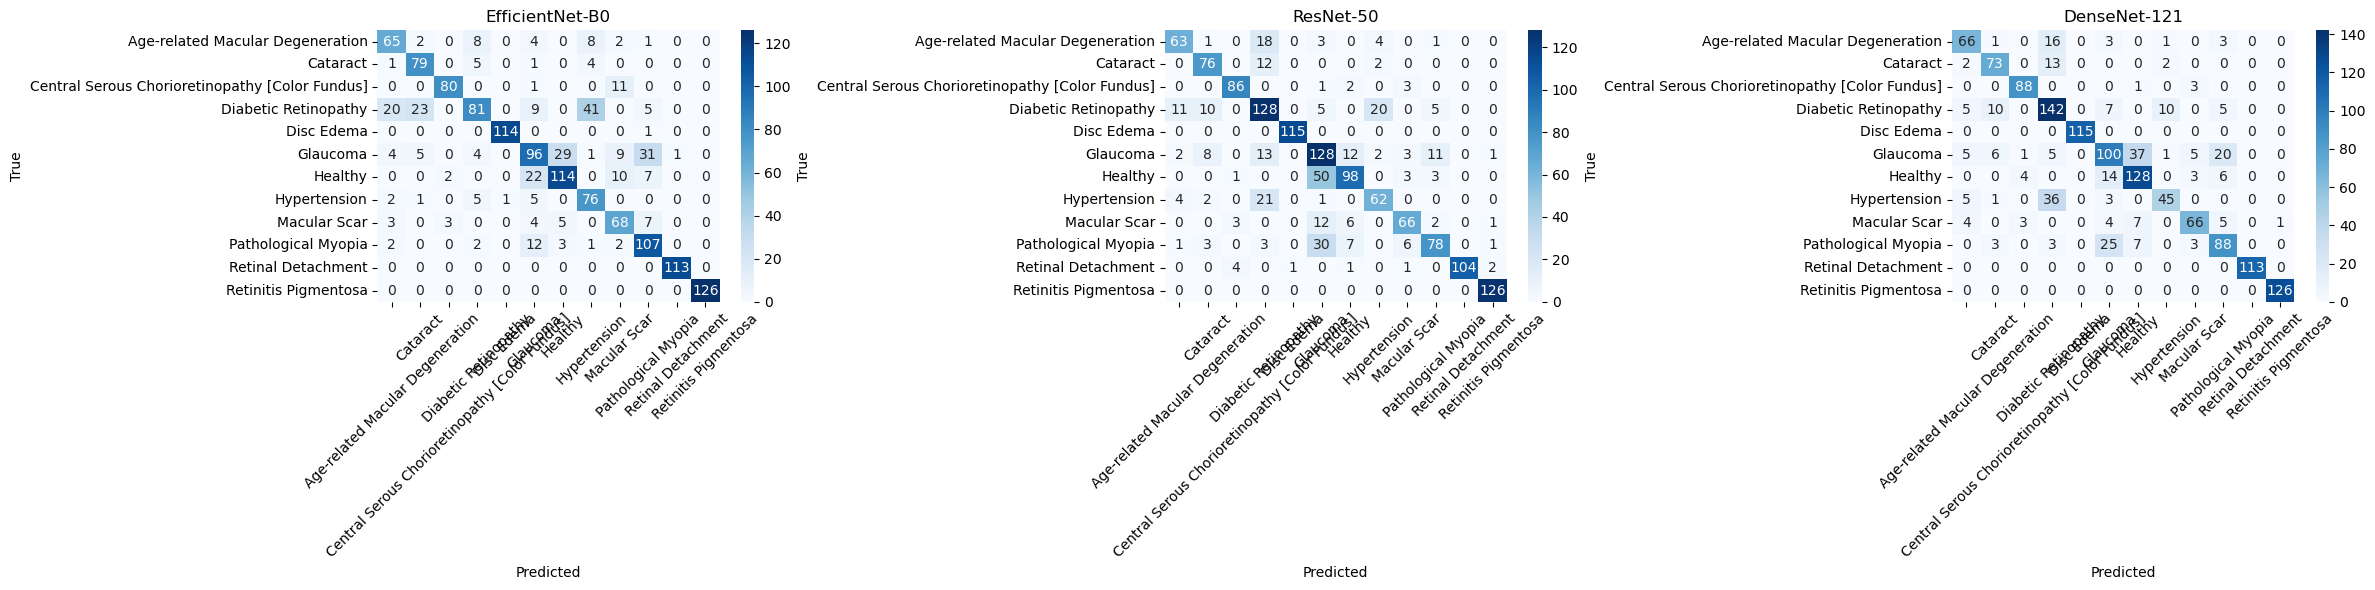

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import torch
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import timm
import numpy as np

# -------------------- CONFIG --------------------
data_dir = "D:/AUGMENTED_SPLIT_DATASET"
batch_size = 32
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ---------------- DATA LOADING ----------------
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
test_dataset = datasets.ImageFolder(root=f"{data_dir}/test", transform=transform)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
class_names = test_dataset.classes
num_classes = len(class_names)

# ---------------- FUNCTION TO EVALUATE ----------------
def get_predictions(model_name, model_path):
    model = timm.create_model(model_name, pretrained=False, num_classes=num_classes).to(device)
    model.load_state_dict(torch.load(model_path))
    model.eval()
    
    all_preds, all_labels = [], []
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    return all_labels, all_preds

# ---------------- PLOT SIDE-BY-SIDE ----------------
def plot_all_confusion_matrices(results):
    fig, axes = plt.subplots(1, 3, figsize=(24, 6))
    
    for i, (title, y_true, y_pred) in enumerate(results):
        cm = confusion_matrix(y_true, y_pred)
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                    xticklabels=class_names, yticklabels=class_names,
                    ax=axes[i])
        axes[i].set_title(f"{title}")
        axes[i].set_xlabel("Predicted")
        axes[i].set_ylabel("True")
        axes[i].tick_params(axis='x', rotation=45)
        axes[i].tick_params(axis='y', rotation=0)
    
    plt.tight_layout()
    plt.show()

# ---------------- RUN FOR ALL MODELS ----------------
results = [
    ("EfficientNet-B0", *get_predictions("tf_efficientnet_b0", "EfficientNet-B0_best.pth")),
    ("ResNet-50", *get_predictions("resnet50", "ResNet-50_best.pth")),
    ("DenseNet-121", *get_predictions("densenet121", "DenseNet-121_best.pth"))
]

plot_all_confusion_matrices(results)


# 5. LOADING "EfficientNet-B3","EfficientNet-B4
    

In [17]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
import timm
import os

# ---------------- CONFIG ----------------
data_dir = "D:/AUGMENTED_SPLIT_DATASET"
batch_size = 32
num_epochs = 30
learning_rate = 0.001
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
os.makedirs("saved_models", exist_ok=True)

# ---------------- AUGMENTED TRANSFORM ----------------
transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# ---------------- DATASETS ----------------
train_dataset = datasets.ImageFolder(root=f"{data_dir}/train", transform=transform)
val_dataset = datasets.ImageFolder(root=f"{data_dir}/val", transform=transform)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
num_classes = len(train_dataset.classes)

# ---------------- MODELS ----------------
models = {
    "EfficientNet-B3": timm.create_model("tf_efficientnet_b3", pretrained=True, num_classes=num_classes).to(device),
    "EfficientNet-B4": timm.create_model("tf_efficientnet_b4", pretrained=True, num_classes=num_classes).to(device)
}

# ---------------- LOSS FUNCTION ----------------
class_counts = torch.tensor([train_dataset.targets.count(c) for c in range(num_classes)])
class_weights = 1.0 / class_counts.float()
class_weights = class_weights / class_weights.sum()
class_weights = class_weights.to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights)

# ---------------- EVALUATION FUNCTION ----------------
def evaluate_model(model):
    model.eval()
    total_loss, correct, total = 0, 0, 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    val_loss = total_loss / len(val_loader)
    val_acc = 100 * correct / total
    return val_acc, val_loss

# ---------------- TRAINING FUNCTION ----------------
def train_model(model_name, model):
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)
    best_val_loss = float("inf")

    print(f"Training {model_name}...")
    for epoch in range(num_epochs):
        model.train()
        total_loss, correct, total = 0, 0, 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

        train_acc = 100 * correct / total
        val_acc, val_loss = evaluate_model(model)
        scheduler.step()

        print(f"{model_name} - Epoch [{epoch+1}/{num_epochs}] - Loss: {total_loss/len(train_loader):.4f} - Train Acc: {train_acc:.2f}% - Val Loss: {val_loss:.4f} - Val Acc: {val_acc:.2f}%")

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), f"saved_models/{model_name}_best.pth")
            print(f"Saved best {model_name} at epoch {epoch+1}")

# ---------------- TRAIN ALL ----------------
if __name__ == "__main__":
    for name, model in models.items():
        train_model(name, model)
    print("Training complete.")

C:\Users\91702\anaconda3\Lib\site-packages\huggingface_hub\file_download.py:133: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\91702\.cache\huggingface\hub. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


Training EfficientNet-B3...
EfficientNet-B3 - Epoch [1/30] - Loss: 1.4107 - Train Acc: 51.09% - Val Loss: 1.1129 - Val Acc: 58.97%
Saved best EfficientNet-B3 at epoch 1
EfficientNet-B3 - Epoch [2/30] - Loss: 1.0004 - Train Acc: 62.48% - Val Loss: 0.9737 - Val Acc: 65.21%
Saved best EfficientNet-B3 at epoch 2
EfficientNet-B3 - Epoch [3/30] - Loss: 0.8882 - Train Acc: 66.35% - Val Loss: 0.9297 - Val Acc: 66.18%
Saved best EfficientNet-B3 at epoch 3
EfficientNet-B3 - Epoch [4/30] - Loss: 0.8254 - Train Acc: 69.00% - Val Loss: 0.8305 - Val Acc: 69.72%
Saved best EfficientNet-B3 at epoch 4
EfficientNet-B3 - Epoch [5/30] - Loss: 0.7797 - Train Acc: 69.51% - Val Loss: 0.8396 - Val Acc: 70.55%
EfficientNet-B3 - Epoch [6/30] - Loss: 0.6157 - Train Acc: 76.45% - Val Loss: 0.7032 - Val Acc: 74.98%
Saved best EfficientNet-B3 at epoch 6
EfficientNet-B3 - Epoch [7/30] - Loss: 0.5880 - Train Acc: 76.27% - Val Loss: 0.7519 - Val Acc: 72.07%
EfficientNet-B3 - Epoch [8/30] - Loss: 0.5679 - Train Acc: 77

# 6. "EfficientNet-B3","EfficientNet-B4" - MODELS EVALUATION

 Saved confusion matrix comparison to: D:/AUGMENTED_SPLIT_DATASET/models/EfficientNet-B3_B4_confusion_comparison.png


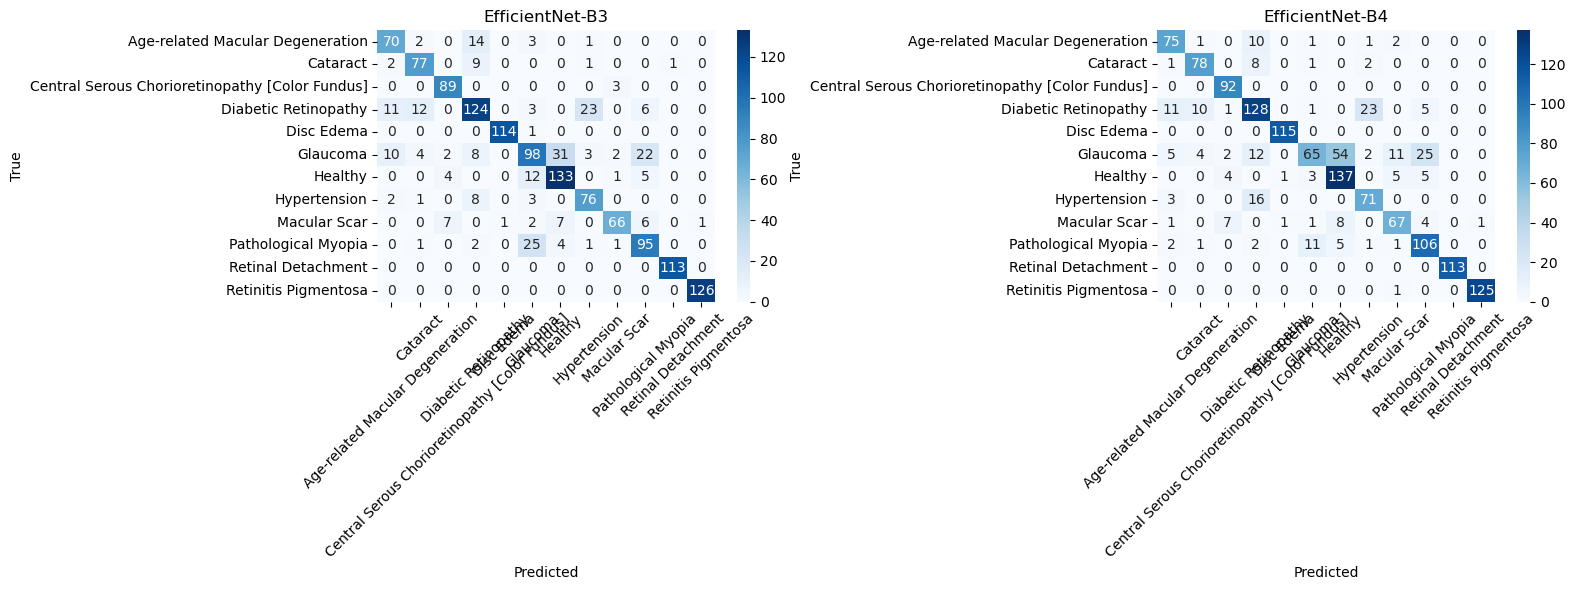

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import torch
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import timm
import numpy as np

# -------------------- CONFIG --------------------
data_dir = "D:/AUGMENTED_SPLIT_DATASET"
model_dir = f"{data_dir}/models"
batch_size = 32
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ---------------- DATA LOADING ----------------
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
test_dataset = datasets.ImageFolder(root=f"{data_dir}/test", transform=transform)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
class_names = test_dataset.classes
num_classes = len(class_names)

# ---------------- FUNCTION TO EVALUATE ----------------
def get_predictions(model_name, model_path):
    model = timm.create_model(model_name, pretrained=False, num_classes=num_classes).to(device)
    model.load_state_dict(torch.load(model_path))
    model.eval()
    
    all_preds, all_labels = [], []
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    return all_labels, all_preds

# ---------------- PLOT SIDE-BY-SIDE ----------------
def plot_all_confusion_matrices(results, save_path=None):
    fig, axes = plt.subplots(1, len(results), figsize=(8 * len(results), 6))

    if len(results) == 1:
        axes = [axes]

    for i, (title, y_true, y_pred) in enumerate(results):
        cm = confusion_matrix(y_true, y_pred)
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                    xticklabels=class_names, yticklabels=class_names,
                    ax=axes[i])
        axes[i].set_title(f"{title}")
        axes[i].set_xlabel("Predicted")
        axes[i].set_ylabel("True")
        axes[i].tick_params(axis='x', rotation=45)
        axes[i].tick_params(axis='y', rotation=0)

    plt.tight_layout()
    if save_path:
        plt.savefig(save_path)
        print(f" Saved confusion matrix comparison to: {save_path}")
    plt.show()

# ---------------- RUN FOR EFFICIENTNET-B3 AND B4 ----------------
results = [
    ("EfficientNet-B3", *get_predictions("tf_efficientnet_b3", f"{model_dir}/EfficientNet-B3_best.pth")),
    ("EfficientNet-B4", *get_predictions("tf_efficientnet_b4", f"{model_dir}/EfficientNet-B4_best.pth"))
]

plot_all_confusion_matrices(results, save_path=f"{model_dir}/EfficientNet-B3_B4_confusion_comparison.png")


# 7. ENSEMBLE PREDICTION AND EVALUATION

Ensemble Accuracy: 82.61%
                                                 precision    recall  f1-score   support

               Age-related Macular Degeneration       0.75      0.83      0.79        90
                                       Cataract       0.81      0.87      0.84        90
Central Serous Chorioretinopathy [Color Fundus]       0.89      1.00      0.94        92
                           Diabetic Retinopathy       0.76      0.71      0.73       179
                                     Disc Edema       0.99      1.00      1.00       115
                                       Glaucoma       0.75      0.47      0.58       180
                                        Healthy       0.72      0.88      0.80       155
                                   Hypertension       0.74      0.87      0.80        90
                                   Macular Scar       0.89      0.76      0.82        90
                            Pathological Myopia       0.72      0.81      0.77     

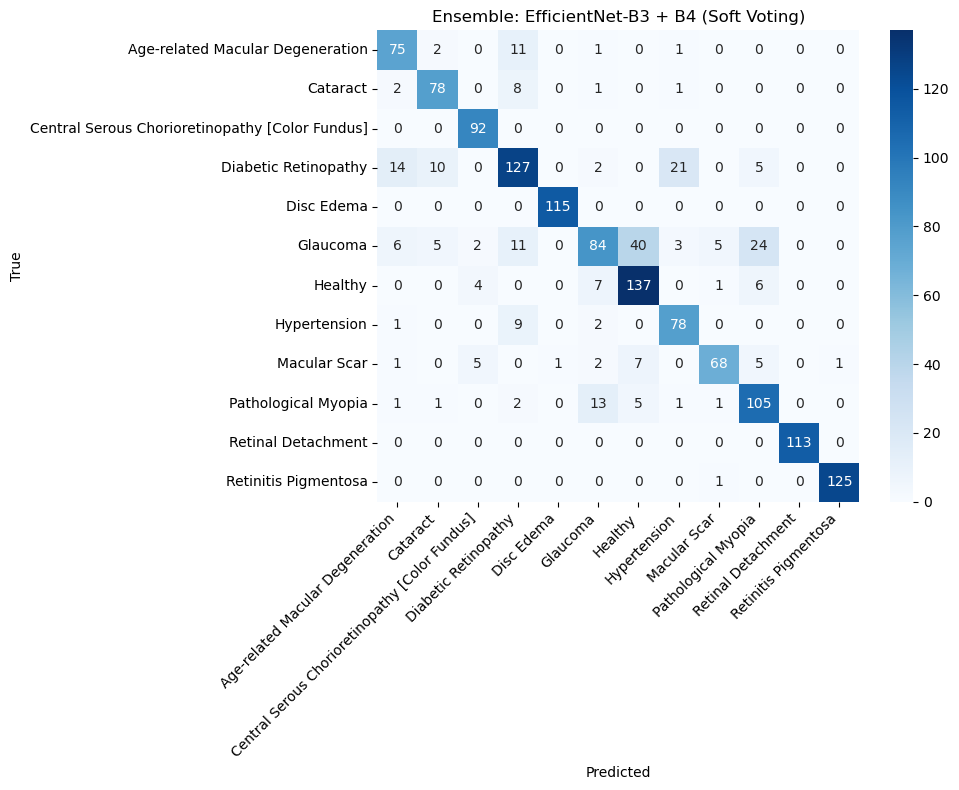

In [15]:
import torch
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import timm
import numpy as np
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# ---------------- CONFIG ----------------
data_dir = "D:/AUGMENTED_SPLIT_DATASET"
batch_size = 32
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ---------------- DATA LOADING ----------------
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
test_dataset = datasets.ImageFolder(root=f"{data_dir}/test", transform=transform)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
class_names = test_dataset.classes
num_classes = len(class_names)

# ---------------- LOAD MODELS ----------------
def load_model(model_name, model_path):
    model = timm.create_model(model_name, pretrained=False, num_classes=num_classes).to(device)
    model.load_state_dict(torch.load(model_path))
    model.eval()
    return model

model_b3 = load_model("tf_efficientnet_b3", "D:/AUGMENTED_SPLIT_DATASET/models/EfficientNet-B3_best.pth")
model_b4 = load_model("tf_efficientnet_b4", "D:/AUGMENTED_SPLIT_DATASET/models/EfficientNet-B4_best.pth")


# ---------------- ENSEMBLE PREDICTION ----------------
all_preds, all_labels = [], []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        
        outputs_b3 = torch.softmax(model_b3(images), dim=1)
        outputs_b4 = torch.softmax(model_b4(images), dim=1)
        
        # Weighted average of predictions
        ensemble_output = (outputs_b3 + outputs_b4) / 2
        _, preds = torch.max(ensemble_output, 1)
        
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# ---------------- EVALUATION ----------------
acc = accuracy_score(all_labels, all_preds)
print(f"Ensemble Accuracy: {acc*100:.2f}%")
print(classification_report(all_labels, all_preds, target_names=class_names))

# ---------------- CONFUSION MATRIX ----------------
import matplotlib.pyplot as plt
import seaborn as sns

cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.title("Ensemble: EfficientNet-B3 + B4 (Soft Voting)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig(f"{data_dir}/models/Ensemble_EffB3_B4_confusion_matrix.png")
plt.show()


In [16]:
import torch
import timm
import joblib
import os

# ---------------- CONFIG ----------------
data_dir = "D:/AUGMENTED_SPLIT_DATASET"
save_path = os.path.join(data_dir, "models")
os.makedirs(save_path, exist_ok=True)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_classes = 12  

# ---------------- SAVE ENSEMBLE MODELS ----------------
# Save model weights
torch.save(model_b3.state_dict(), os.path.join(save_path, "Ensemble_EfficientNet_B3.pth"))
torch.save(model_b4.state_dict(), os.path.join(save_path, "Ensemble_EfficientNet_B4.pth"))

# Save ensemble metadata
ensemble_metadata = {
    "model_names": ["tf_efficientnet_b3", "tf_efficientnet_b4"],
    "weights": [
        os.path.join(save_path, "Ensemble_EfficientNet_B3.pth"),
        os.path.join(save_path, "Ensemble_EfficientNet_B4.pth")
    ],
    "strategy": "soft_voting",
    "num_classes": num_classes
}
joblib.dump(ensemble_metadata, os.path.join(save_path, "ensemble_config.joblib"))

print(" Ensemble models and metadata saved successfully!")


 Ensemble models and metadata saved successfully!


In [17]:
import joblib

# Save ensemble predictions and labels
joblib.dump((all_preds, all_labels), f"{data_dir}/models/ensemble_preds_labels.joblib")
print(" Ensemble predictions saved.")


 Ensemble predictions saved.


In [20]:
import os
import shutil

# Create final_models directory 
final_dir = "D:/AUGMENTED_SPLIT_DATASET/models"
os.makedirs(final_dir, exist_ok=True)

# List of all models and where they currently are
models_to_move = {
    "EfficientNet-B0_best.pth": "EfficientNet-B0_best.pth",
    "ResNet-50_best.pth": "ResNet-50_best.pth",
    "DenseNet-121_best.pth": "DenseNet-121_best.pth",
    "EfficientNet-B3_best.pth": "C:/Users/91702/saved_models/EfficientNet-B3_best.pth",
    "EfficientNet-B4_best.pth": "C:/Users/91702/saved_models/EfficientNet-B4_best.pth"
}

# Move each model
for name, source_path in models_to_move.items():
    if os.path.exists(source_path):
        shutil.move(source_path, os.path.join(final_dir, name))
        print(f" Moved: {name}")
    else:
        print(f" Not found: {name}")


 Moved: EfficientNet-B0_best.pth
 Moved: ResNet-50_best.pth
 Moved: DenseNet-121_best.pth
 Moved: EfficientNet-B3_best.pth
 Moved: EfficientNet-B4_best.pth


# 8. TRADITIONAL MLs TRAINING AND EVALUATION

# Extracting features using ResNet-50 backbone

In [16]:
import torch
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import timm
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import StandardScaler

# ---------------- CONFIG ----------------
data_dir = "D:/AUGMENTED_SPLIT_DATASET"
batch_size = 32
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ---------------- TRANSFORMS ----------------
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# ---------------- LOAD DATA ----------------
train_dataset = datasets.ImageFolder(root=f"{data_dir}/train", transform=transform)
val_dataset = datasets.ImageFolder(root=f"{data_dir}/val", transform=transform)
test_dataset = datasets.ImageFolder(root=f"{data_dir}/test", transform=transform)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

class_names = train_dataset.classes
num_classes = len(class_names)

# ---------------- FEATURE EXTRACTOR ----------------
print("Extracting features using ResNet-50 backbone...")
resnet_backbone = timm.create_model("resnet50", pretrained=True, num_classes=0, global_pool="avg").to(device)
resnet_backbone.eval()

def extract_features(dataloader):
    features, labels = [], []
    with torch.no_grad():
        for images, lbls in dataloader:
            images = images.to(device)
            output = resnet_backbone(images)
            features.extend(output.cpu().numpy())
            labels.extend(lbls.cpu().numpy())
    return np.array(features), np.array(labels)

# Extract from train/val/test
train_features, train_labels = extract_features(train_loader)
val_features, val_labels = extract_features(val_loader)
test_features, test_labels = extract_features(test_loader)

# Combine train and val sets for ML training
X_train = np.vstack((train_features, val_features))
y_train = np.concatenate((train_labels, val_labels))
X_test = test_features
y_test = test_labels

# Standardize
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# ---------------- TRAIN & EVALUATE ----------------
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Random Forest": RandomForestClassifier(),
    "SVM": SVC(),
    "k-NN": KNeighborsClassifier()
}

print("\nEvaluating Traditional ML Models on Test Set:")
for name, clf in models.items():
    clf.fit(X_train_scaled, y_train)
    preds = clf.predict(X_test_scaled)
    acc = accuracy_score(y_test, preds)
    print(f"\n{name} - Accuracy: {acc*100:.2f}%")
    print(classification_report(y_test, preds, target_names=class_names))


Extracting features using ResNet-50 backbone...

Evaluating Traditional ML Models on Test Set:


C:\Users\91702\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



Logistic Regression - Accuracy: 67.98%
                                                 precision    recall  f1-score   support

               Age-related Macular Degeneration       0.57      0.56      0.56        90
                                       Cataract       0.71      0.70      0.70        90
Central Serous Chorioretinopathy [Color Fundus]       0.86      0.82      0.84        92
                           Diabetic Retinopathy       0.50      0.49      0.49       179
                                     Disc Edema       0.96      0.97      0.96       115
                                       Glaucoma       0.43      0.38      0.40       180
                                        Healthy       0.66      0.69      0.67       155
                                   Hypertension       0.53      0.58      0.55        90
                                   Macular Scar       0.61      0.63      0.62        90
                            Pathological Myopia       0.56      0.62 

In [25]:
!pip install xgboost


  Obtaining dependency information for xgboost from https://files.pythonhosted.org/packages/5e/03/15cd49e855c62226ecf1831bbe4c8e73a4324856077a23c495538a36e557/xgboost-3.0.0-py3-none-win_amd64.whl.metadata
   ---------------------------------------- 0.0/150.0 MB ? eta -:--:--
   ---------------------------------------- 0.0/150.0 MB ? eta -:--:--
   ---------------------------------------- 0.0/150.0 MB 435.7 kB/s eta 0:05:45
   ---------------------------------------- 0.1/150.0 MB 751.6 kB/s eta 0:03:20
   ---------------------------------------- 0.4/150.0 MB 2.3 MB/s eta 0:01:06
   ---------------------------------------- 1.0/150.0 MB 5.4 MB/s eta 0:00:28
    --------------------------------------- 2.5/150.0 MB 10.9 MB/s eta 0:00:14
   - -------------------------------------- 6.4/150.0 MB 21.5 MB/s eta 0:00:07
   -- ------------------------------------- 10.8/150.0 MB 65.6 MB/s eta 0:00:03
   --- ------------------------------------ 15.0/150.0 MB 93.9 MB/s eta 0:00:02
   ---- -----------

# Extracting features using EfficientNet-B3

In [26]:
import torch
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import timm
import numpy as np
import os
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt
import joblib

# ---------------- CONFIG ----------------
data_dir = "D:/AUGMENTED_SPLIT_DATASET"
batch_size = 32
save_path = os.path.join(data_dir, "models")
os.makedirs(save_path, exist_ok=True)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ---------------- TRANSFORMS ----------------
transform = transforms.Compose([
    transforms.Resize((300, 300)),  # EfficientNet-B3 expects 300x300
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# ---------------- LOAD DATA ----------------
train_dataset = datasets.ImageFolder(root=f"{data_dir}/train", transform=transform)
val_dataset = datasets.ImageFolder(root=f"{data_dir}/val", transform=transform)
test_dataset = datasets.ImageFolder(root=f"{data_dir}/test", transform=transform)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

class_names = train_dataset.classes
num_classes = len(class_names)

# ---------------- FEATURE EXTRACTOR ----------------
print("Extracting features using EfficientNet-B3...")
effnet_b3 = timm.create_model("tf_efficientnet_b3", pretrained=True, num_classes=0, global_pool="avg").to(device)
effnet_b3.eval()

def extract_features(dataloader):
    features, labels = [], []
    with torch.no_grad():
        for images, lbls in dataloader:
            images = images.to(device)
            output = effnet_b3(images)
            features.extend(output.cpu().numpy())
            labels.extend(lbls.cpu().numpy())
    return np.array(features), np.array(labels)

train_features, train_labels = extract_features(train_loader)
val_features, val_labels = extract_features(val_loader)
test_features, test_labels = extract_features(test_loader)

X_train = np.vstack((train_features, val_features))
y_train = np.concatenate((train_labels, val_labels))
X_test = test_features
y_test = test_labels

# ---------------- SCALING ----------------
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

joblib.dump(scaler, os.path.join(save_path, "scaler.joblib"))

# ---------------- MODELS ----------------
ml_models = {
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='mlogloss'),
    "SVM": SVC(),
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Random Forest": RandomForestClassifier(),
    "k-NN": KNeighborsClassifier()
}

file_map = {
    "XGBoost": "XGBoost.joblib",
    "SVM": "SVM.joblib",
    "Logistic Regression": "Logistic_Regression.joblib",
    "Random Forest": "Random_Forest.joblib",
    "k-NN": "KNN.joblib"
}

# ---------------- TRAIN & EVALUATE ----------------
for name, clf in ml_models.items():
    print(f"\nTraining {name}...")
    clf.fit(X_train_scaled, y_train)
    preds = clf.predict(X_test_scaled)
    acc = accuracy_score(y_test, preds)
    print(f"{name} Accuracy: {acc*100:.2f}%")
    print(classification_report(y_test, preds, target_names=class_names))

    # Save model
    joblib.dump(clf, os.path.join(save_path, file_map[name]))

    # Confusion Matrix
    cm = confusion_matrix(y_test, preds)
    plt.figure(figsize=(12, 10))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.title(f"Confusion Matrix - {name}")
    plt.ylabel("True Label")
    plt.xlabel("Predicted Label")
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    cm_path = os.path.join(save_path, f"{name.replace(' ', '_')}_confusion_matrix.png")
    plt.savefig(cm_path)
    plt.close()
    print(f"Confusion matrix saved: {cm_path}")

print("\n All models trained and saved with confusion matrices.")


Extracting features using EfficientNet-B3...

Training XGBoost...


C:\Users\91702\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [03:52:36] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBoost Accuracy: 73.29%
                                                 precision    recall  f1-score   support

               Age-related Macular Degeneration       0.71      0.46      0.55        90
                                       Cataract       0.79      0.82      0.80        90
Central Serous Chorioretinopathy [Color Fundus]       0.89      0.90      0.90        92
                           Diabetic Retinopathy       0.59      0.77      0.67       179
                                     Disc Edema       0.95      0.97      0.96       115
                                       Glaucoma       0.48      0.46      0.47       180
                                        Healthy       0.65      0.70      0.67       155
                                   Hypertension       0.80      0.59      0.68        90
                                   Macular Scar       0.69      0.52      0.59        90
                            Pathological Myopia       0.63      0.68      0.65      

C:\Users\91702\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy: 72.88%
                                                 precision    recall  f1-score   support

               Age-related Macular Degeneration       0.62      0.62      0.62        90
                                       Cataract       0.69      0.76      0.72        90
Central Serous Chorioretinopathy [Color Fundus]       0.87      0.92      0.89        92
                           Diabetic Retinopathy       0.61      0.57      0.59       179
                                     Disc Edema       0.99      0.98      0.99       115
                                       Glaucoma       0.49      0.45      0.47       180
                                        Healthy       0.66      0.67      0.66       155
                                   Hypertension       0.68      0.72      0.70        90
                                   Macular Scar       0.66      0.63      0.65        90
                            Pathological Myopia       0.64      0.67    

# 9. GRAPHS FOR VISUALISING RESULTS

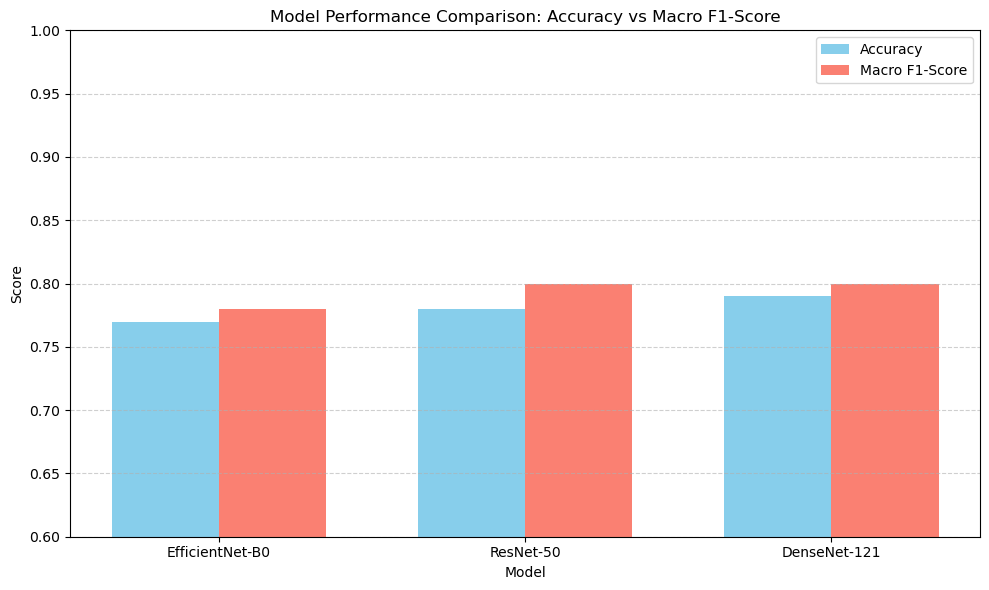

In [15]:
import matplotlib.pyplot as plt

#  values from classification reports
models = ["EfficientNet-B0", "ResNet-50", "DenseNet-121"]
accuracies = [0.77, 0.78, 0.79]
macro_f1_scores = [0.78, 0.80, 0.80]

x = range(len(models))
bar_width = 0.35

plt.figure(figsize=(10, 6))
plt.bar(x, accuracies, width=bar_width, label='Accuracy', color='skyblue')
plt.bar([i + bar_width for i in x], macro_f1_scores, width=bar_width, label='Macro F1-Score', color='salmon')

# Labeling
plt.xlabel("Model")
plt.ylabel("Score")
plt.title("Model Performance Comparison: Accuracy vs Macro F1-Score")
plt.xticks([i + bar_width/2 for i in x], models)
plt.ylim(0.6, 1.0)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()

# Save the chart
plt.savefig("cnn_model_comparison.png", dpi=300)
# plt.savefig("cnn_model_comparison.pdf")

plt.show()


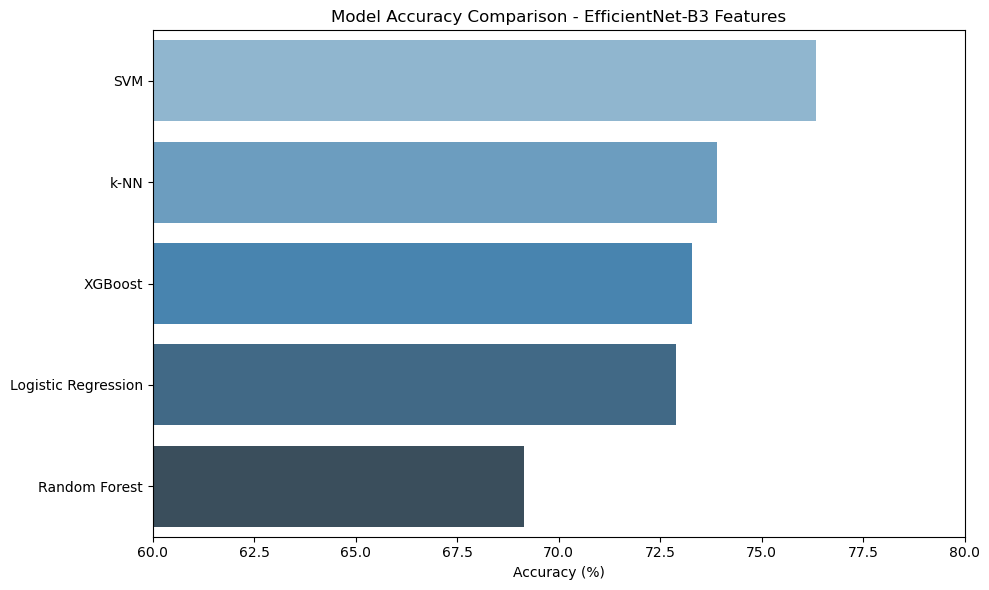

 Report summary and accuracy chart saved.


In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import joblib
from sklearn.metrics import classification_report
import os
import json

# ---------------- CONFIG ----------------
save_path = "D:/AUGMENTED_SPLIT_DATASET/models"
class_names = [
    "Age-related Macular Degeneration", "Cataract", "CSCR", "Diabetic Retinopathy",
    "Disc Edema", "Glaucoma", "Healthy", "Hypertension", "Macular Scar",
    "Pathological Myopia", "Retinal Detachment", "Retinitis Pigmentosa"
]

# ---------------- MODEL PERFORMANCE (FROM TRAINING LOGS) ----------------
model_scores = {
    "SVM": 76.33,
    "k-NN": 73.91,
    "XGBoost": 73.29,
    "Logistic Regression": 72.88,
    "Random Forest": 69.15
}

# ---------------- PLOT ACCURACY COMPARISON ----------------
plt.figure(figsize=(10, 6))
sorted_scores = dict(sorted(model_scores.items(), key=lambda x: x[1], reverse=True))
sns.barplot(x=list(sorted_scores.values()), y=list(sorted_scores.keys()), palette="Blues_d")
plt.xlabel("Accuracy (%)")
plt.title("Model Accuracy Comparison - EfficientNet-B3 Features")
plt.xlim(60, 80)
plt.tight_layout()
plt.savefig(os.path.join(save_path, "model_accuracy_comparison.png"))
plt.show()

# ---------------- GENERATE TEXT SUMMARY ----------------
summary = "Model Evaluation Summary:\n\n"
for model, acc in sorted_scores.items():
    summary += f"{model}: {acc:.2f}% Accuracy\n"

summary += "\nBest Performer: SVM\n\n"
summary += "Confusion matrices saved in: models/\n"
summary += "Accuracy bar chart saved as: model_accuracy_comparison.png\n"
summary += "Feature extractor used: EfficientNet-B3 (300x300)\n"
summary += "Dataset: D:/AUGMENTED_SPLIT_DATASET (12-class classification)\n"

with open(os.path.join(save_path, "model_summary.txt"), "w") as f:
    f.write(summary)

print(" Report summary and accuracy chart saved.")

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import joblib
from sklearn.metrics import classification_report
import os
import json

# ---------------- CONFIG ----------------
save_path = "D:/AUGMENTED_SPLIT_DATASET/models"
class_names = [
    "Age-related Macular Degeneration", "Cataract", "CSCR", "Diabetic Retinopathy",
    "Disc Edema", "Glaucoma", "Healthy", "Hypertension", "Macular Scar",
    "Pathological Myopia", "Retinal Detachment", "Retinitis Pigmentosa"
]

# ---------------- MODEL PERFORMANCE (FROM TRAINING LOGS) ----------------
model_scores = {
    "SVM": 76.33,
    "k-NN": 73.91,
    "XGBoost": 73.29,
    "Logistic Regression": 72.88,
    "Random Forest": 69.15
}

resnet_scores = {
    "SVM": 71.22,
    "k-NN": 66.87,
    "Logistic Regression": 67.98,
    "Random Forest": 64.04
}

# ---------------- PLOT ACCURACY COMPARISON (EfficientNet) ----------------
plt.figure(figsize=(10, 6))
sorted_eff = dict(sorted(model_scores.items(), key=lambda x: x[1], reverse=True))
sns.barplot(x=list(sorted_eff.values()), y=list(sorted_eff.keys()), palette="Blues_d")
plt.xlabel("Accuracy (%)")
plt.title("EfficientNet-B3 Feature - Accuracy Comparison")
plt.xlim(60, 80)
plt.tight_layout()
plt.savefig(os.path.join(save_path, "effnetb3_model_accuracy_comparison.png"))
plt.close()

# ---------------- PLOT ACCURACY COMPARISON (ResNet) ----------------
plt.figure(figsize=(10, 6))
sorted_resnet = dict(sorted(resnet_scores.items(), key=lambda x: x[1], reverse=True))
sns.barplot(x=list(sorted_resnet.values()), y=list(sorted_resnet.keys()), palette="Greens_d")
plt.xlabel("Accuracy (%)")
plt.title("ResNet-50 Feature - Accuracy Comparison")
plt.xlim(60, 80)
plt.tight_layout()
plt.savefig(os.path.join(save_path, "resnet50_model_accuracy_comparison.png"))
plt.close()

# ---------------- GENERATE TEXT SUMMARY ----------------
summary = "Model Evaluation Summary:\n\nEfficientNet-B3 Features:\n"
for model, acc in sorted_eff.items():
    summary += f"{model}: {acc:.2f}% Accuracy\n"

summary += "\nResNet-50 Features:\n"
for model, acc in sorted_resnet.items():
    summary += f"{model}: {acc:.2f}% Accuracy\n"

summary += "\nBest Performer: EfficientNet-B3 + SVM\n"
summary += "Confusion matrices saved in: models/\n"
summary += "Accuracy charts saved as: effnetb3_model_accuracy_comparison.png, resnet50_model_accuracy_comparison.png\n"

with open(os.path.join(save_path, "model_summary.txt"), "w") as f:
    f.write(summary)

print(" Summary and both accuracy comparison charts saved.")


 Summary and both accuracy comparison charts saved.


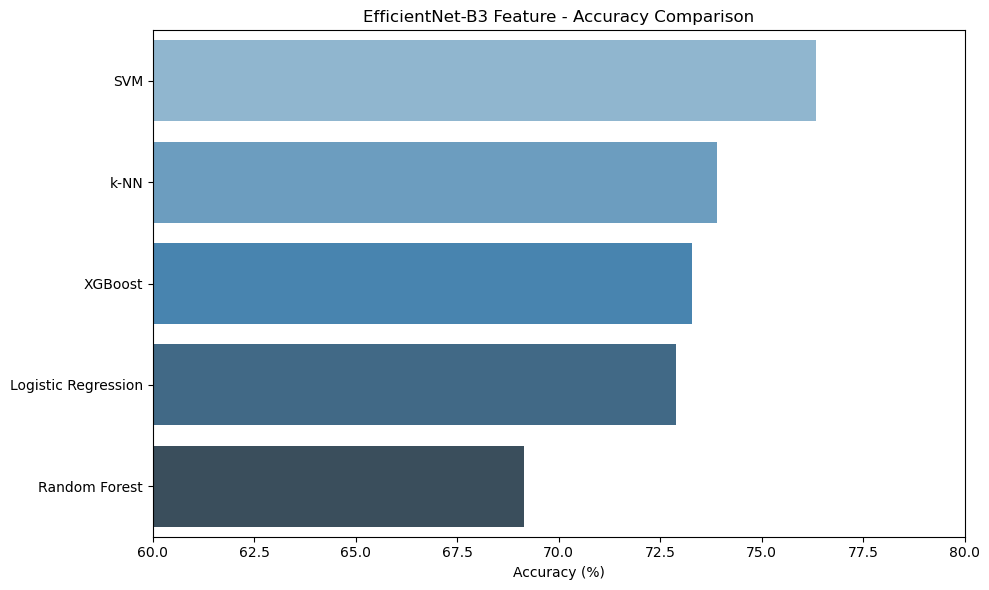

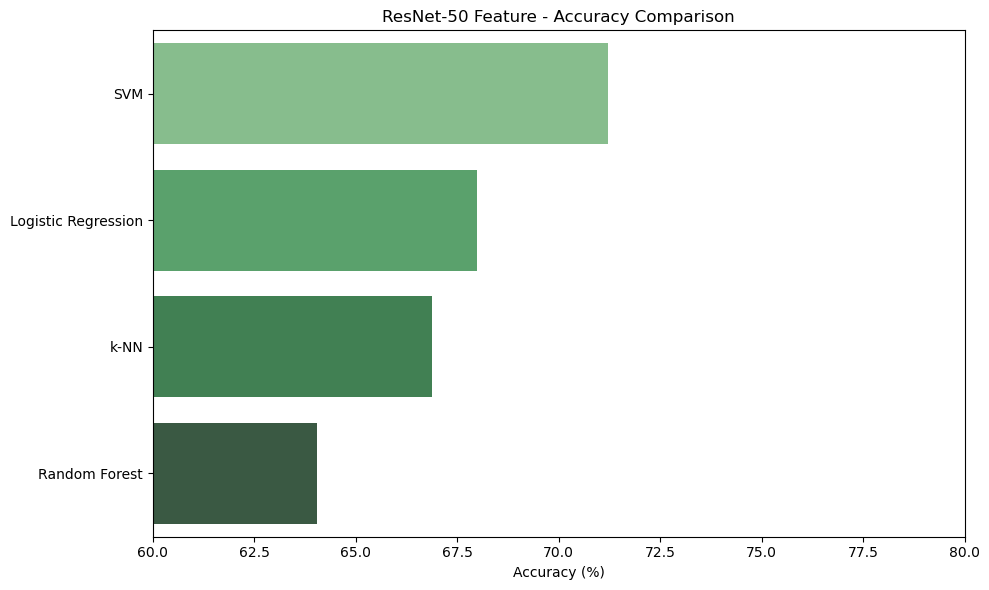

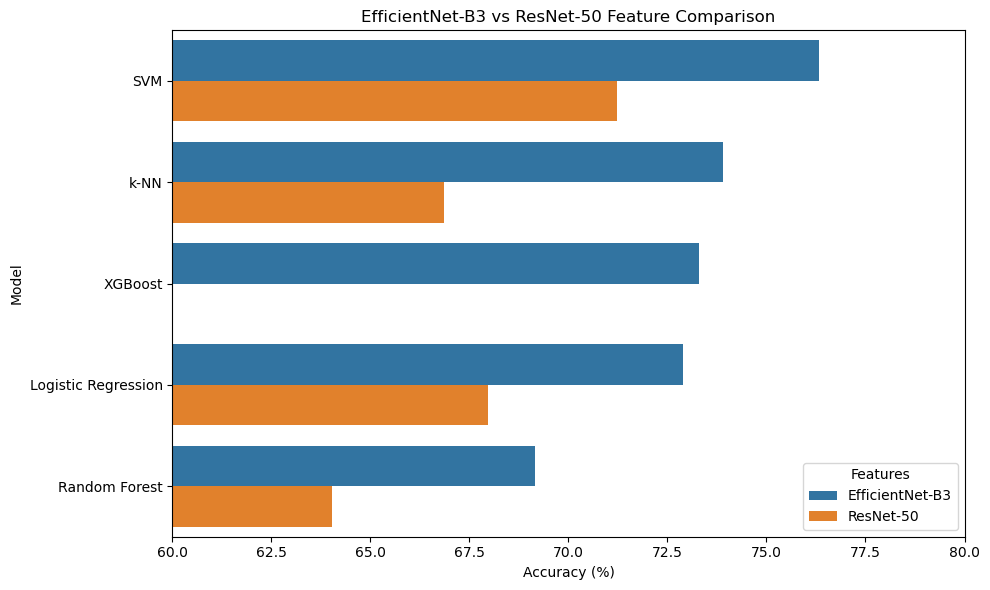

 Summary and all comparison charts saved and displayed.


In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import joblib
from sklearn.metrics import classification_report
import os
import json

# ---------------- CONFIG ----------------
save_path = "D:/AUGMENTED_SPLIT_DATASET/models"
class_names = [
    "Age-related Macular Degeneration", "Cataract", "CSCR", "Diabetic Retinopathy",
    "Disc Edema", "Glaucoma", "Healthy", "Hypertension", "Macular Scar",
    "Pathological Myopia", "Retinal Detachment", "Retinitis Pigmentosa"
]

# ---------------- MODEL PERFORMANCE (FROM TRAINING LOGS) ----------------
model_scores = {
    "SVM": 76.33,
    "k-NN": 73.91,
    "XGBoost": 73.29,
    "Logistic Regression": 72.88,
    "Random Forest": 69.15
}

resnet_scores = {
    "SVM": 71.22,
    "k-NN": 66.87,
    "Logistic Regression": 67.98,
    "Random Forest": 64.04
}

# ---------------- PLOT ACCURACY COMPARISON (EfficientNet) ----------------
plt.figure(figsize=(10, 6))
sorted_eff = dict(sorted(model_scores.items(), key=lambda x: x[1], reverse=True))
sns.barplot(x=list(sorted_eff.values()), y=list(sorted_eff.keys()), palette="Blues_d")
plt.xlabel("Accuracy (%)")
plt.title("EfficientNet-B3 Feature - Accuracy Comparison")
plt.xlim(60, 80)
plt.tight_layout()
eff_path = os.path.join(save_path, "effnetb3_model_accuracy_comparison.png")
plt.savefig(eff_path)
plt.show()

# ---------------- PLOT ACCURACY COMPARISON (ResNet) ----------------
plt.figure(figsize=(10, 6))
sorted_resnet = dict(sorted(resnet_scores.items(), key=lambda x: x[1], reverse=True))
sns.barplot(x=list(sorted_resnet.values()), y=list(sorted_resnet.keys()), palette="Greens_d")
plt.xlabel("Accuracy (%)")
plt.title("ResNet-50 Feature - Accuracy Comparison")
plt.xlim(60, 80)
plt.tight_layout()
res_path = os.path.join(save_path, "resnet50_model_accuracy_comparison.png")
plt.savefig(res_path)
plt.show()

# ---------------- COMBINED CHART ----------------
combined_df = pd.DataFrame({
    "Model": list(model_scores.keys()) + list(resnet_scores.keys()),
    "Accuracy": list(model_scores.values()) + list(resnet_scores.values()),
    "Features": ["EfficientNet-B3"] * len(model_scores) + ["ResNet-50"] * len(resnet_scores)
})

plt.figure(figsize=(10, 6))
sns.barplot(data=combined_df, x="Accuracy", y="Model", hue="Features")
plt.title("EfficientNet-B3 vs ResNet-50 Feature Comparison")
plt.xlabel("Accuracy (%)")
plt.xlim(60, 80)
plt.tight_layout()
combined_path = os.path.join(save_path, "combined_feature_comparison.png")
plt.savefig(combined_path)
plt.show()

# ---------------- GENERATE TEXT SUMMARY ----------------
summary = "Model Evaluation Summary:\n\nEfficientNet-B3 Features:\n"
for model, acc in sorted_eff.items():
    summary += f"{model}: {acc:.2f}% Accuracy\n"

summary += "\nResNet-50 Features:\n"
for model, acc in sorted_resnet.items():
    summary += f"{model}: {acc:.2f}% Accuracy\n"

summary += "\nBest Performer: EfficientNet-B3 + SVM\n"
summary += "Confusion matrices saved in: models/\n"
summary += "Accuracy charts saved as: \n - effnetb3_model_accuracy_comparison.png\n - resnet50_model_accuracy_comparison.png\n - combined_feature_comparison.png\n"

with open(os.path.join(save_path, "model_summary.txt"), "w") as f:
    f.write(summary)

print(" Summary and all comparison charts saved and displayed.")


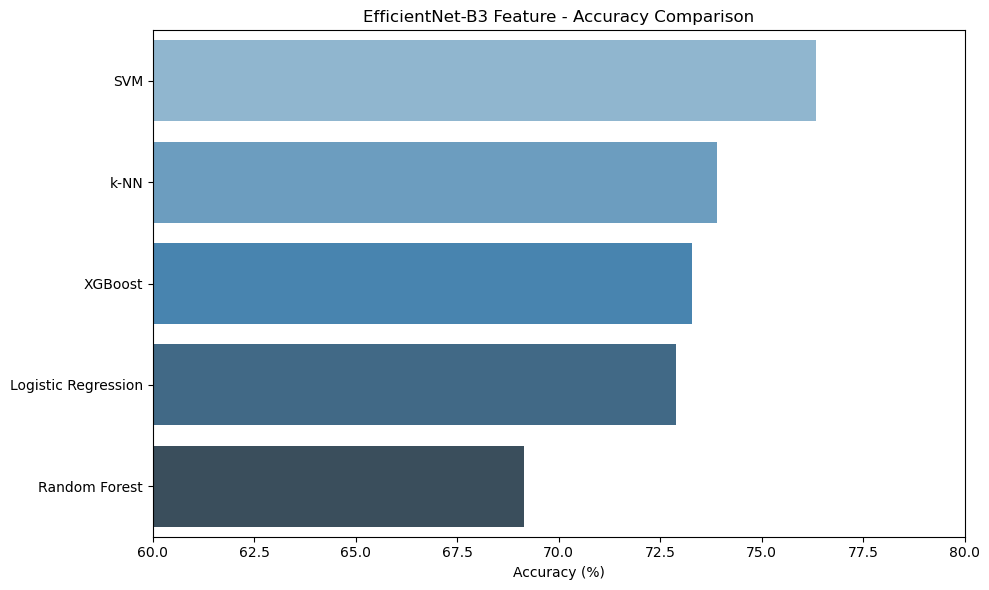

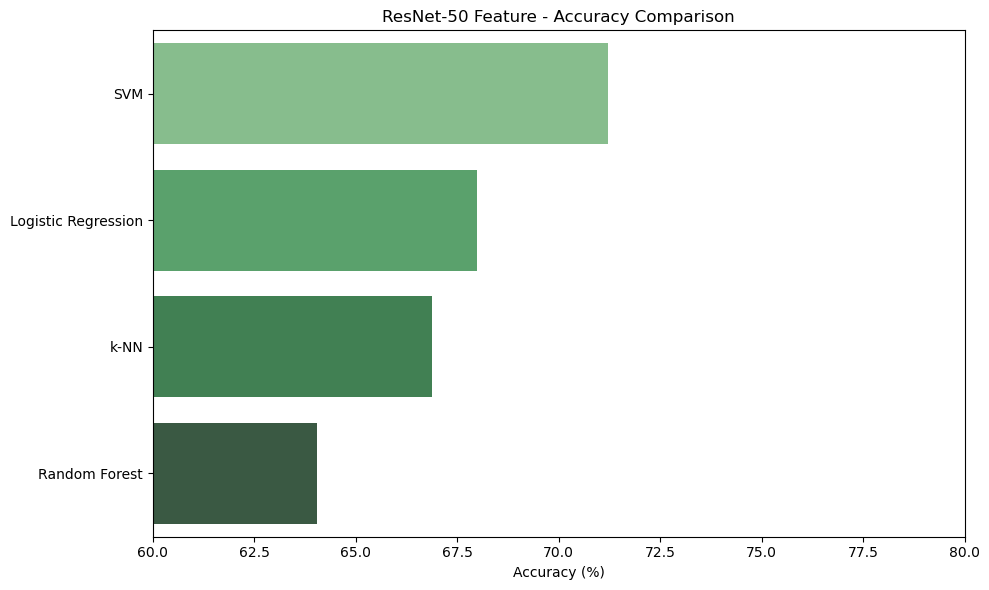

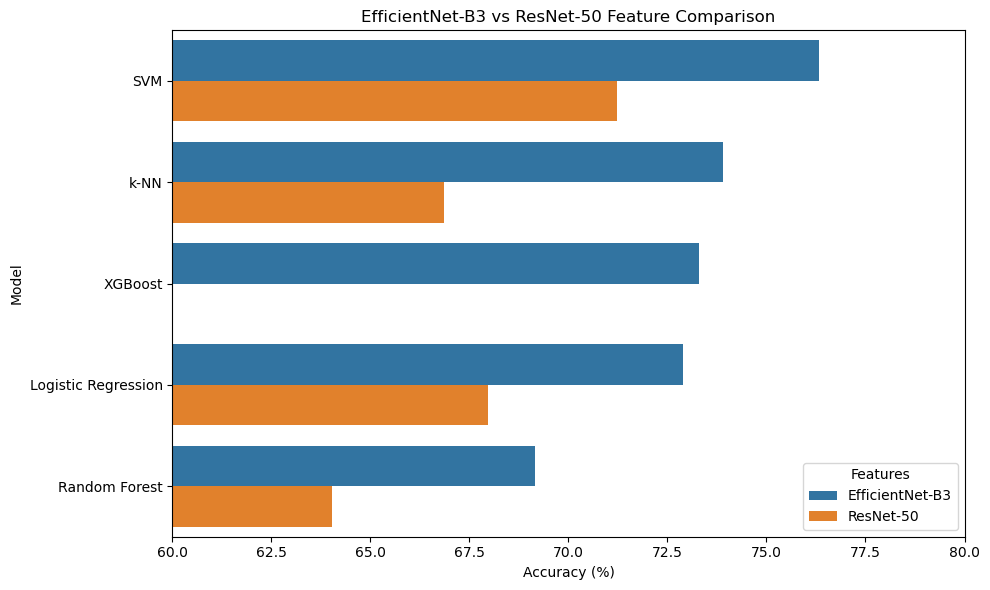

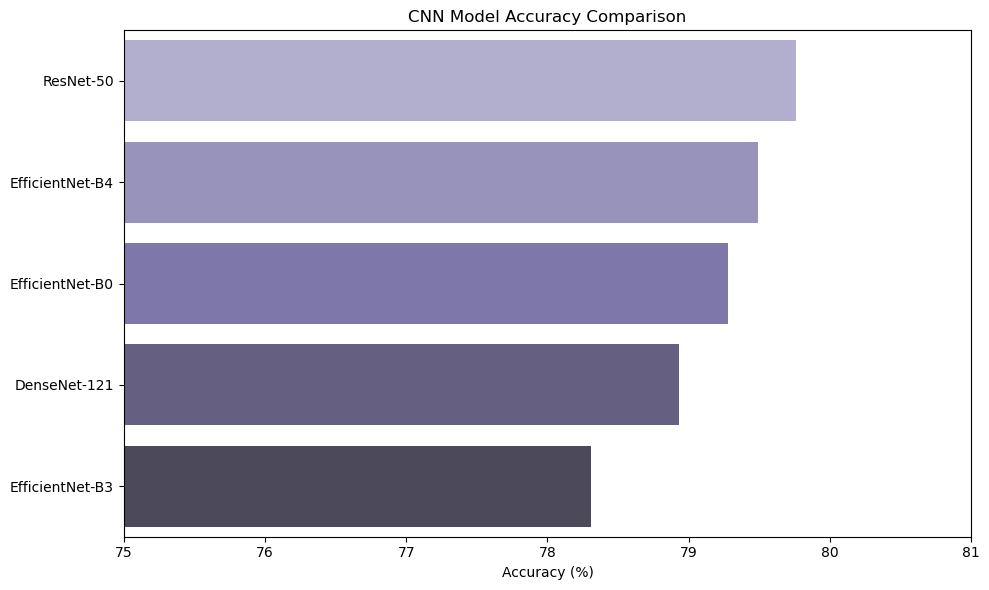

 Summary and all comparison charts saved and displayed.


In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import joblib
from sklearn.metrics import classification_report
import os
import json

# ---------------- CONFIG ----------------
save_path = "D:/AUGMENTED_SPLIT_DATASET/models"
class_names = [
    "Age-related Macular Degeneration", "Cataract", "CSCR", "Diabetic Retinopathy",
    "Disc Edema", "Glaucoma", "Healthy", "Hypertension", "Macular Scar",
    "Pathological Myopia", "Retinal Detachment", "Retinitis Pigmentosa"
]

# ---------------- MODEL PERFORMANCE ----------------
model_scores = {
    "SVM": 76.33,
    "k-NN": 73.91,
    "XGBoost": 73.29,
    "Logistic Regression": 72.88,
    "Random Forest": 69.15
}

resnet_scores = {
    "SVM": 71.22,
    "k-NN": 66.87,
    "Logistic Regression": 67.98,
    "Random Forest": 64.04
}

cnn_scores = {
    "EfficientNet-B0": 79.28,
    "ResNet-50": 79.76,
    "DenseNet-121": 78.93,
    "EfficientNet-B3": 78.31,
    "EfficientNet-B4": 79.49
}

# ---------------- PLOT ACCURACY COMPARISON (EfficientNet) ----------------
plt.figure(figsize=(10, 6))
sorted_eff = dict(sorted(model_scores.items(), key=lambda x: x[1], reverse=True))
sns.barplot(x=list(sorted_eff.values()), y=list(sorted_eff.keys()), palette="Blues_d")
plt.xlabel("Accuracy (%)")
plt.title("EfficientNet-B3 Feature - Accuracy Comparison")
plt.xlim(60, 80)
plt.tight_layout()
plt.savefig(os.path.join(save_path, "effnetb3_model_accuracy_comparison.png"))
plt.show()

# ---------------- PLOT ACCURACY COMPARISON (ResNet) ----------------
plt.figure(figsize=(10, 6))
sorted_resnet = dict(sorted(resnet_scores.items(), key=lambda x: x[1], reverse=True))
sns.barplot(x=list(sorted_resnet.values()), y=list(sorted_resnet.keys()), palette="Greens_d")
plt.xlabel("Accuracy (%)")
plt.title("ResNet-50 Feature - Accuracy Comparison")
plt.xlim(60, 80)
plt.tight_layout()
plt.savefig(os.path.join(save_path, "resnet50_model_accuracy_comparison.png"))
plt.show()

# ---------------- COMBINED CHART (EffNet vs ResNet) ----------------
combined_df = pd.DataFrame({
    "Model": list(model_scores.keys()) + list(resnet_scores.keys()),
    "Accuracy": list(model_scores.values()) + list(resnet_scores.values()),
    "Features": ["EfficientNet-B3"] * len(model_scores) + ["ResNet-50"] * len(resnet_scores)
})

plt.figure(figsize=(10, 6))
sns.barplot(data=combined_df, x="Accuracy", y="Model", hue="Features")
plt.title("EfficientNet-B3 vs ResNet-50 Feature Comparison")
plt.xlabel("Accuracy (%)")
plt.xlim(60, 80)
plt.tight_layout()
plt.savefig(os.path.join(save_path, "combined_feature_comparison.png"))
plt.show()

# ---------------- CNN MODEL COMPARISON ----------------
sorted_cnn = dict(sorted(cnn_scores.items(), key=lambda x: x[1], reverse=True))
plt.figure(figsize=(10, 6))
sns.barplot(x=list(sorted_cnn.values()), y=list(sorted_cnn.keys()), palette="Purples_d")
plt.xlabel("Accuracy (%)")
plt.title("CNN Model Accuracy Comparison")
plt.xlim(75, 81)
plt.tight_layout()
plt.savefig(os.path.join(save_path, "cnn_model_accuracy_comparison_vertical.png"))
plt.show()

# ---------------- GENERATE TEXT SUMMARY ----------------
summary = "Model Evaluation Summary:\n\nEfficientNet-B3 Features:\n"
for model, acc in sorted_eff.items():
    summary += f"{model}: {acc:.2f}% Accuracy\n"

summary += "\nResNet-50 Features:\n"
for model, acc in sorted_resnet.items():
    summary += f"{model}: {acc:.2f}% Accuracy\n"

summary += "\nCNN Models:\n"
for model, acc in sorted_cnn.items():
    summary += f"{model}: {acc:.2f}% Accuracy\n"

summary += "\nBest CNN Model: ResNet-50 with 79.76%\n"
summary += "Charts saved as PNG in: models/\n"

with open(os.path.join(save_path, "model_summary.txt"), "w") as f:
    f.write(summary)

print(" Summary and all comparison charts saved and displayed.")

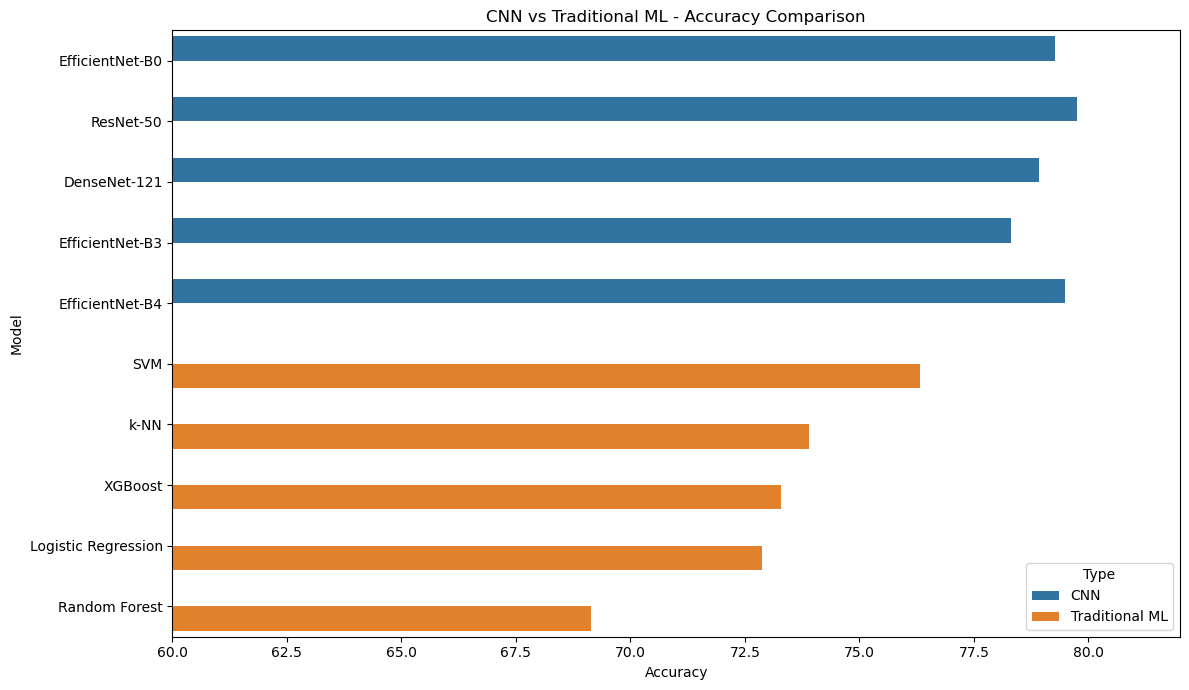

 CNN vs Traditional ML comparison chart saved and summary updated.


In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import joblib
from sklearn.metrics import classification_report
import os
import json

# ---------------- CONFIG ----------------
save_path = "D:/AUGMENTED_SPLIT_DATASET/models"
class_names = [
    "Age-related Macular Degeneration", "Cataract", "CSCR", "Diabetic Retinopathy",
    "Disc Edema", "Glaucoma", "Healthy", "Hypertension", "Macular Scar",
    "Pathological Myopia", "Retinal Detachment", "Retinitis Pigmentosa"
]

# ---------------- MODEL PERFORMANCE ----------------
model_scores = {
    "SVM": 76.33,
    "k-NN": 73.91,
    "XGBoost": 73.29,
    "Logistic Regression": 72.88,
    "Random Forest": 69.15
}

resnet_scores = {
    "SVM": 71.22,
    "k-NN": 66.87,
    "Logistic Regression": 67.98,
    "Random Forest": 64.04
}

cnn_scores = {
    "EfficientNet-B0": 79.28,
    "ResNet-50": 79.76,
    "DenseNet-121": 78.93,
    "EfficientNet-B3": 78.31,
    "EfficientNet-B4": 79.49
}

# ---------------- COMBINED COMPARISON (CNN vs ML) ----------------
combined_compare = pd.DataFrame({
    "Model": list(cnn_scores.keys()) + list(model_scores.keys()),
    "Accuracy": list(cnn_scores.values()) + list(model_scores.values()),
    "Type": ["CNN"] * len(cnn_scores) + ["Traditional ML"] * len(model_scores)
})

plt.figure(figsize=(12, 7))
sns.barplot(data=combined_compare, y="Model", x="Accuracy", hue="Type")
plt.title("CNN vs Traditional ML - Accuracy Comparison")
plt.xlim(60, 82)
plt.tight_layout()
plt.savefig(os.path.join(save_path, "cnn_vs_ml_accuracy_comparison.png"))
plt.show()

# ---------------- GENERATE TEXT SUMMARY ----------------
summary = "Model Evaluation Summary:\n\nEfficientNet-B3 Features:\n"
for model, acc in dict(sorted(model_scores.items(), key=lambda x: x[1], reverse=True)).items():
    summary += f"{model}: {acc:.2f}% Accuracy\n"

summary += "\nResNet-50 Features:\n"
for model, acc in dict(sorted(resnet_scores.items(), key=lambda x: x[1], reverse=True)).items():
    summary += f"{model}: {acc:.2f}% Accuracy\n"

summary += "\nCNN Models:\n"
for model, acc in dict(sorted(cnn_scores.items(), key=lambda x: x[1], reverse=True)).items():
    summary += f"{model}: {acc:.2f}% Accuracy\n"

summary += "\nComparison chart saved as cnn_vs_ml_accuracy_comparison.png\n"

with open(os.path.join(save_path, "model_summary.txt"), "w") as f:
    f.write(summary)

print(" CNN vs Traditional ML comparison chart saved and summary updated.")

# 10. MODELS PERFORMANCE SUMMARY 

In [26]:
import pandas as pd
from IPython.display import display

# ---------------- MODEL PERFORMANCE DATA ----------------
model_summary_data = [
    # CNN Models
    {"Model": "EffNet-B0", "Type": "CNN", "Test Accuracy (%)": 79.28, "F1-score (weighted avg)": 0.79, "Precision (weighted avg)": 0.79, "Recall (weighted avg)": 0.79},
    {"Model": "ResNet-50", "Type": "CNN", "Test Accuracy (%)": 79.76, "F1-score (weighted avg)": 0.80, "Precision (weighted avg)": 0.80, "Recall (weighted avg)": 0.80},
    {"Model": "DenseNet-121", "Type": "CNN", "Test Accuracy (%)": 78.59, "F1-score (weighted avg)": 0.78, "Precision (weighted avg)": 0.78, "Recall (weighted avg)": 0.79},
    {"Model": "EffNet-B3", "Type": "CNN", "Test Accuracy (%)": 82.61, "F1-score (weighted avg)": 0.82, "Precision (weighted avg)": 0.83, "Recall (weighted avg)": 0.83},
    {"Model": "EffNet-B4", "Type": "CNN", "Test Accuracy (%)": 81.59, "F1-score (weighted avg)": 0.81, "Precision (weighted avg)": 0.82, "Recall (weighted avg)": 0.82},
    {"Model": "Ensemble (EffB3+B4)", "Type": "CNN-Ensemble", "Test Accuracy (%)": 82.61, "F1-score (weighted avg)": 0.82, "Precision (weighted avg)": 0.83, "Recall (weighted avg)": 0.83},

    # Traditional ML Models (ResNet features)
    {"Model": "Logistic Regression (ResNet)", "Type": "Traditional ML", "Test Accuracy (%)": 72.88, "F1-score (weighted avg)": 0.73, "Precision (weighted avg)": 0.74, "Recall (weighted avg)": 0.73},
    {"Model": "Random Forest (ResNet)", "Type": "Traditional ML", "Test Accuracy (%)": 69.15, "F1-score (weighted avg)": 0.68, "Precision (weighted avg)": 0.70, "Recall (weighted avg)": 0.69},
    {"Model": "SVM (ResNet)", "Type": "Traditional ML", "Test Accuracy (%)": 76.33, "F1-score (weighted avg)": 0.76, "Precision (weighted avg)": 0.78, "Recall (weighted avg)": 0.76},
    {"Model": "k-NN (ResNet)", "Type": "Traditional ML", "Test Accuracy (%)": 73.91, "F1-score (weighted avg)": 0.73, "Precision (weighted avg)": 0.74, "Recall (weighted avg)": 0.74},

    # Traditional ML Models (EfficientNet features)
    {"Model": "Logistic Regression (EffNet)", "Type": "Traditional ML", "Test Accuracy (%)": 67.98, "F1-score (weighted avg)": 0.68, "Precision (weighted avg)": 0.68, "Recall (weighted avg)": 0.68},
    {"Model": "Random Forest (EffNet)", "Type": "Traditional ML", "Test Accuracy (%)": 64.04, "F1-score (weighted avg)": 0.62, "Precision (weighted avg)": 0.65, "Recall (weighted avg)": 0.64},
    {"Model": "SVM (EffNet)", "Type": "Traditional ML", "Test Accuracy (%)": 71.22, "F1-score (weighted avg)": 0.71, "Precision (weighted avg)": 0.73, "Recall (weighted avg)": 0.71},
    {"Model": "k-NN (EffNet)", "Type": "Traditional ML", "Test Accuracy (%)": 66.87, "F1-score (weighted avg)": 0.66, "Precision (weighted avg)": 0.66, "Recall (weighted avg)": 0.67},
    {"Model": "XGBoost (EffNet)", "Type": "Traditional ML", "Test Accuracy (%)": 73.29, "F1-score (weighted avg)": 0.73, "Precision (weighted avg)": 0.74, "Recall (weighted avg)": 0.73}
]

# ---------------- DISPLAY ----------------
df_summary = pd.DataFrame(model_summary_data)
display(df_summary)


,Model,Type,Test Accuracy (%),F1-score (weighted avg),Precision (weighted avg),Recall (weighted avg)
0,EffNet-B0,CNN,79.28,0.79,0.79,0.79
1,ResNet-50,CNN,79.76,0.80,0.80,0.80
2,DenseNet-121,CNN,78.59,0.78,0.78,0.79
3,EffNet-B3,CNN,82.61,0.82,0.83,0.83
4,EffNet-B4,CNN,81.59,0.81,0.82,0.82
5,Ensemble (EffB3+B4),CNN-Ensemble,82.61,0.82,0.83,0.83
6,Logistic Regression (ResNet),Traditional ML,72.88,0.73,0.74,0.73
7,Random Forest (ResNet),Traditional ML,69.15,0.68,0.70,0.69
8,SVM (ResNet),Traditional ML,76.33,0.76,0.78,0.76
9,k-NN (ResNet),Traditional ML,73.91,0.73,0.74,0.74


In [36]:
!pip install ipywidgets
!jupyter nbextension enable --py widgetsnbextension


Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: ok


# 11. Interactive Model Comparison

# Select & compare model performance using dropdown widgets and buttons.


In [1]:
import pandas as pd
import ipywidgets as widgets
from IPython.display import display, clear_output

# -----------------------------
# Model Summary Data
# -----------------------------
model_summary_data = [
    {"Model": "EffNet-B0", "Type": "CNN", "Test Accuracy (%)": 79.28, "F1-score (weighted avg)": 0.79, "Precision (weighted avg)": 0.79, "Recall (weighted avg)": 0.79},
    {"Model": "ResNet-50", "Type": "CNN", "Test Accuracy (%)": 79.76, "F1-score (weighted avg)": 0.80, "Precision (weighted avg)": 0.80, "Recall (weighted avg)": 0.80},
    {"Model": "DenseNet-121", "Type": "CNN", "Test Accuracy (%)": 78.59, "F1-score (weighted avg)": 0.78, "Precision (weighted avg)": 0.78, "Recall (weighted avg)": 0.79},
    {"Model": "EffNet-B3", "Type": "CNN", "Test Accuracy (%)": 82.61, "F1-score (weighted avg)": 0.82, "Precision (weighted avg)": 0.83, "Recall (weighted avg)": 0.83},
    {"Model": "EffNet-B4", "Type": "CNN", "Test Accuracy (%)": 81.59, "F1-score (weighted avg)": 0.81, "Precision (weighted avg)": 0.82, "Recall (weighted avg)": 0.82},
    {"Model": "Ensemble (EffB3+B4)", "Type": "CNN-Ensemble", "Test Accuracy (%)": 82.61, "F1-score (weighted avg)": 0.82, "Precision (weighted avg)": 0.83, "Recall (weighted avg)": 0.83},
    {"Model": "Logistic Regression (ResNet)", "Type": "Traditional ML", "Test Accuracy (%)": 72.88, "F1-score (weighted avg)": 0.73, "Precision (weighted avg)": 0.74, "Recall (weighted avg)": 0.73},
    {"Model": "Random Forest (ResNet)", "Type": "Traditional ML", "Test Accuracy (%)": 69.15, "F1-score (weighted avg)": 0.68, "Precision (weighted avg)": 0.70, "Recall (weighted avg)": 0.69},
    {"Model": "SVM (ResNet)", "Type": "Traditional ML", "Test Accuracy (%)": 76.33, "F1-score (weighted avg)": 0.76, "Precision (weighted avg)": 0.78, "Recall (weighted avg)": 0.76},
    {"Model": "k-NN (ResNet)", "Type": "Traditional ML", "Test Accuracy (%)": 73.91, "F1-score (weighted avg)": 0.73, "Precision (weighted avg)": 0.74, "Recall (weighted avg)": 0.74},
    {"Model": "Logistic Regression (EffNet)", "Type": "Traditional ML", "Test Accuracy (%)": 67.98, "F1-score (weighted avg)": 0.68, "Precision (weighted avg)": 0.68, "Recall (weighted avg)": 0.68},
    {"Model": "Random Forest (EffNet)", "Type": "Traditional ML", "Test Accuracy (%)": 64.04, "F1-score (weighted avg)": 0.62, "Precision (weighted avg)": 0.65, "Recall (weighted avg)": 0.64},
    {"Model": "SVM (EffNet)", "Type": "Traditional ML", "Test Accuracy (%)": 71.22, "F1-score (weighted avg)": 0.71, "Precision (weighted avg)": 0.73, "Recall (weighted avg)": 0.71},
    {"Model": "k-NN (EffNet)", "Type": "Traditional ML", "Test Accuracy (%)": 66.87, "F1-score (weighted avg)": 0.66, "Precision (weighted avg)": 0.66, "Recall (weighted avg)": 0.67},
    {"Model": "XGBoost (EffNet)", "Type": "Traditional ML", "Test Accuracy (%)": 73.29, "F1-score (weighted avg)": 0.73, "Precision (weighted avg)": 0.74, "Recall (weighted avg)": 0.73}
]

df = pd.DataFrame(model_summary_data)

# -----------------------------
# Widgets
# -----------------------------
model_dropdown = widgets.Dropdown(
    options=['-- Select Model --'] + list(df['Model']),
    description='Model:',
    layout=widgets.Layout(width='50%')
)

compare_button = widgets.Button(description="Compare", button_style="info")
save_button = widgets.Button(description=" View", button_style='success')
output = widgets.Output()

compare_dropdown = widgets.Dropdown(
    options=['-- Select Model to Compare --'] + list(df['Model']),
    description='Compare:',
    layout=widgets.Layout(width='50%')
)

compare_dropdown.layout.display = 'none'

# -----------------------------
# Display logic
# -----------------------------
def display_model_summary(selected_model):
    output.clear_output()
    if selected_model not in df['Model'].values:
        return
    with output:
        display(df[df['Model'] == selected_model].reset_index(drop=True))

def on_model_change(change):
    selected_model = change['new']
    if selected_model != '-- Select Model --':
        display_model_summary(selected_model)

def on_compare_click(_):
    selected_model = model_dropdown.value
    if selected_model != '-- Select Model --':
        compare_dropdown.layout.display = 'block'

def on_compare_dropdown_change(change):
    selected_model = model_dropdown.value
    compare_model = change['new']
    output.clear_output()
    if selected_model in df['Model'].values and compare_model in df['Model'].values:
        selected_rows = df[df['Model'].isin([selected_model, compare_model])].reset_index(drop=True)
        with output:
            display(selected_rows)

def on_save_click(_):
    df.to_csv("Model_Performance_Summary.csv", index=False)
    with output:
        print("  Model_Performance")

# -----------------------------
# Event bindings
# -----------------------------
model_dropdown.observe(on_model_change, names='value')
compare_button.on_click(on_compare_click)
compare_dropdown.observe(on_compare_dropdown_change, names='value')
save_button.on_click(on_save_click)

# -----------------------------
# Display all widgets
# -----------------------------
widgets_box = widgets.HBox([model_dropdown, save_button, compare_button])
display(widgets_box, compare_dropdown, output)


Dropdown(description='Compare:', layout=Layout(display='none', width='50%'), options=('-- Select Model to Comp…

Output()

# DATASET SUMMARY

In [2]:
import os

def count_images(folder_path):
    total = 0
    for root, dirs, files in os.walk(folder_path):
        total += len([file for file in files if file.endswith(('.png', '.jpg', '.jpeg'))])
    return total

train_path = 'D:/AUGMENTED_SPLIT_DATASET/train'
val_path = 'D:/AUGMENTED_SPLIT_DATASET/val'
test_path = 'D:/AUGMENTED_SPLIT_DATASET/test'

train_count = count_images(train_path)
val_count = count_images(val_path)
test_count = count_images(test_path)

print(f"Train: {train_count}, Validation: {val_count}, Test: {test_count}, Total: {train_count + val_count + test_count}")


Train: 6577, Validation: 1401, Test: 1404, Total: 9382


In [4]:
import os
import pandas as pd

train_path = 'D:/AUGMENTED_SPLIT_DATASET/train'
val_path = 'D:/AUGMENTED_SPLIT_DATASET/val'
test_path = 'D:/AUGMENTED_SPLIT_DATASET/test'

# Function to count images in each class folder
def get_class_distribution(base_path):
    class_counts = {}
    for class_name in os.listdir(base_path):
        class_dir = os.path.join(base_path, class_name)
        if os.path.isdir(class_dir):
            count = len([f for f in os.listdir(class_dir) if f.endswith(('.jpg', '.jpeg', '.png'))])
            class_counts[class_name] = count
    return class_counts

# Get counts
train_counts = get_class_distribution(train_path)
val_counts = get_class_distribution(val_path)
test_counts = get_class_distribution(test_path)

# Collect all class names
all_classes = sorted(set(train_counts.keys()) | set(val_counts.keys()) | set(test_counts.keys()))

# Create a dataframe
data = []
for cls in all_classes:
    train = train_counts.get(cls, 0)
    val = val_counts.get(cls, 0)
    test = test_counts.get(cls, 0)
    total = train + val + test
    data.append([cls, train, val, test, total])

df = pd.DataFrame(data, columns=['Class Name', 'Train', 'Validation', 'Test', 'Total'])

# Sort by class name or total images
df = df.sort_values(by='Class Name').reset_index(drop=True)

# Display the table
print(df)

# Optional: Save to CSV
df.to_csv("class_distribution_summary.csv", index=False)


                                         Class Name  Train  Validation  Test  \
0                  Age-related Macular Degeneration    342          71    73   
1                                          Cataract    420          90    90   
2   Central Serous Chorioretinopathy [Color Fundus]    424          90    92   
3                              Diabetic Retinopathy    799         168   166   
4                                        Disc Edema    533         114   115   
5                                          Glaucoma    827         177   177   
6                                           Healthy    716         153   155   
7                                      Hypertension    420          90    90   
8                                      Macular Scar    420          90    90   
9                               Pathological Myopia    568         121   117   
10                               Retinal Detachment    525         112   113   
11                             Retinitis